In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split , TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
datos = pd.read_csv('salud_dataset.csv')
datos.head()

,IMC,horas_sueno,actividad,relacion_calorica,clase
0,28.75,5.34,1,0.86,2
1,23.08,8.77,3,1.09,0
2,27.78,5.98,1,1.08,2
3,25.11,7.04,2,1.06,1
4,23.54,8.26,2,1.02,0


In [ ]:
#separamos la variable última o final
datos_y = datos[datos.columns[-1]]
datos_y.head()

,clase
0,2
1,0
2,2
3,1
4,0


In [ ]:
datos_x = datos.drop(columns=['clase'])
datos_x.head()

,IMC,horas_sueno,actividad,relacion_calorica
0,28.75,5.34,1,0.86
1,23.08,8.77,3,1.09
2,27.78,5.98,1,1.08
3,25.11,7.04,2,1.06
4,23.54,8.26,2,1.02


In [ ]:
escalador = StandardScaler()
datos_x = escalador.fit_transform(datos_x)
print(datos_x)


[[ 1.15425726 -0.61526351 -0.1290816  -1.07517524]
 [-0.47822117  1.75432309  1.74166619  0.43269247]
 [ 0.87497965 -0.1731249  -0.1290816   0.36713301]
 ...
 [ 0.61009779 -0.041865   -0.1290816   0.30157354]
 [-2.13949111 -1.36828082 -1.06445549 -2.25524562]
 [-1.20088799  1.07729835  1.74166619 -0.68181844]]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size=0.2, random_state=2)

In [ ]:
print(f'X train:{X_train.shape} X_test:{X_test.shape} y_train:{y_train.shape} y_test:{y_test.shape}')


X train:(400, 4) X_test:(100, 4) y_train:(400,) y_test:(100,)


In [ ]:
n_entradas = X_train.shape[1]
print(n_entradas)

4


TENSORES

In [ ]:
tensor_X_train = torch.from_numpy(X_train).float().to('cuda')
tensor_X_test = torch.from_numpy(X_test).float().to('cuda')
tensor_y_train = torch.from_numpy(y_train.values).long().to('cuda')
tensor_y_test = torch.from_numpy(y_test.values).long().to('cuda')
tensor_y_train = tensor_y_train[:,None]
tensor_y_test = tensor_y_test[:,None]

In [ ]:
test = TensorDataset(tensor_X_test,tensor_y_test)
print(test[0])

(tensor([ 0.8462,  0.1308, -0.1291, -0.1573], device='cuda:0'), tensor([2.], device='cuda:0'))


In [ ]:
tensor_y_train

tensor([[2.],
        [0.],
        [3.],
        [3.],
        [3.],
        [1.],
        [2.],
        [1.],
        [0.],
        [3.],
        [2.],
        [3.],
        [1.],
        [1.],
        [1.],
        [1.],
        [3.],
        [2.],
        [3.],
        [0.],
        [2.],
        [3.],
        [0.],
        [0.],
        [3.],
        [2.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [3.],
        [3.],
        [1.],
        [1.],
        [3.],
        [2.],
        [0.],
        [2.],
        [1.],
        [1.],
        [3.],
        [2.],
        [0.],
        [2.],
        [0.],
        [1.],
        [3.],
        [0.],
        [0.],
        [0.],
        [1.],
        [3.],
        [1.],
        [1.],
        [0.],
        [2.],
        [3.],
        [3.],
        [2.],
        [3.],
        [3.],
        [3.],
        [3.],
        [2.],
        [0.],
        [1.],
        [3.],
        [1.],
        [3.],
        [0.],
      

In [ ]:
class Red_Neuronal(nn.Module):
  def __init__(self,n_entradas):
    super(Red_Neuronal, self).__init__()
    self.linear1 = nn.Linear(n_entradas,16)
    self.linear2 = nn.Linear(16,8)
    self.linear3 = nn.Linear(8,4)

  def forward(self, inputs):
    pred_1 = torch.relu(self.linear1(inputs))
    pred_2 = torch.relu(self.linear2(pred_1))
    pred_f = self.linear3(pred_2) # Removed relu from the output layer
    return pred_f

In [ ]:
tensor_y_train = tensor_y_train.squeeze().long()
tensor_y_test = tensor_y_test.squeeze().long()

learning_rate = 0.001
epochs = 2000
estatus_print = 100

model = Red_Neuronal(n_entradas=n_entradas)
model.to('cuda')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)
print(f'Arquitectura del modelo: {model}')
historico = pd.DataFrame()

print('Entrenando el modelo...')
for epoch in range(epochs + 1):
  model.train()
  optimizer.zero_grad()

  y_pred = model(tensor_X_train)
  loss = loss_fn(input=y_pred, target=tensor_y_train)
  loss.backward()
  optimizer.step()

  if epoch % estatus_print == 0:
    print(f"\nEpoch {epoch} \t Loss: {round(loss.item(),4)}")

  with torch.no_grad():
    model.eval()
    y_pred = model(tensor_X_test)
    y_pred_class = torch.argmax(y_pred, dim=1)
    correct = (y_pred_class == tensor_y_test).sum()
    accuracy = 100 * correct /float(len(tensor_y_test))

    if epoch % estatus_print == 0:
      print("Accuracy: {:.2f}%".format(accuracy.item()))

  df_tmp = pd.DataFrame({
      'Epoch': [epoch],
      'Loss': [round(loss.item(),4)],
      'Accuracy': [round(accuracy.item(),4)]
  })

  historico = pd.concat([historico,df_tmp],ignore_index=True)

  historico.to_csv('historico.csv',index=False)

print(f"Accuracy final: {round(accuracy.item(),4)}")

Arquitectura del modelo: Red_Neuronal(
  (linear1): Linear(in_features=4, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=4, bias=True)
)
Entrenando el modelo...

Epoch 0 	 Loss: 1.3919
Accuracy: 14.00%

Epoch 100 	 Loss: 1.0235
Accuracy: 44.00%

Epoch 200 	 Loss: 0.6917
Accuracy: 60.00%

Epoch 300 	 Loss: 0.5327
Accuracy: 88.00%

Epoch 400 	 Loss: 0.3785
Accuracy: 98.00%

Epoch 500 	 Loss: 0.2477
Accuracy: 99.00%

Epoch 600 	 Loss: 0.1733
Accuracy: 99.00%

Epoch 700 	 Loss: 0.133
Accuracy: 99.00%

Epoch 800 	 Loss: 0.1129
Accuracy: 99.00%

Epoch 900 	 Loss: 0.1004
Accuracy: 99.00%

Epoch 1000 	 Loss: 0.0913
Accuracy: 99.00%

Epoch 1100 	 Loss: 0.0843
Accuracy: 99.00%

Epoch 1200 	 Loss: 0.079
Accuracy: 99.00%

Epoch 1300 	 Loss: 0.0746
Accuracy: 99.00%

Epoch 1400 	 Loss: 0.071
Accuracy: 99.00%

Epoch 1500 	 Loss: 0.0682
Accuracy: 99.00%

Epoch 1600 	 Loss: 0.0656
Accuracy: 99.00%

Epoch 1700 	 

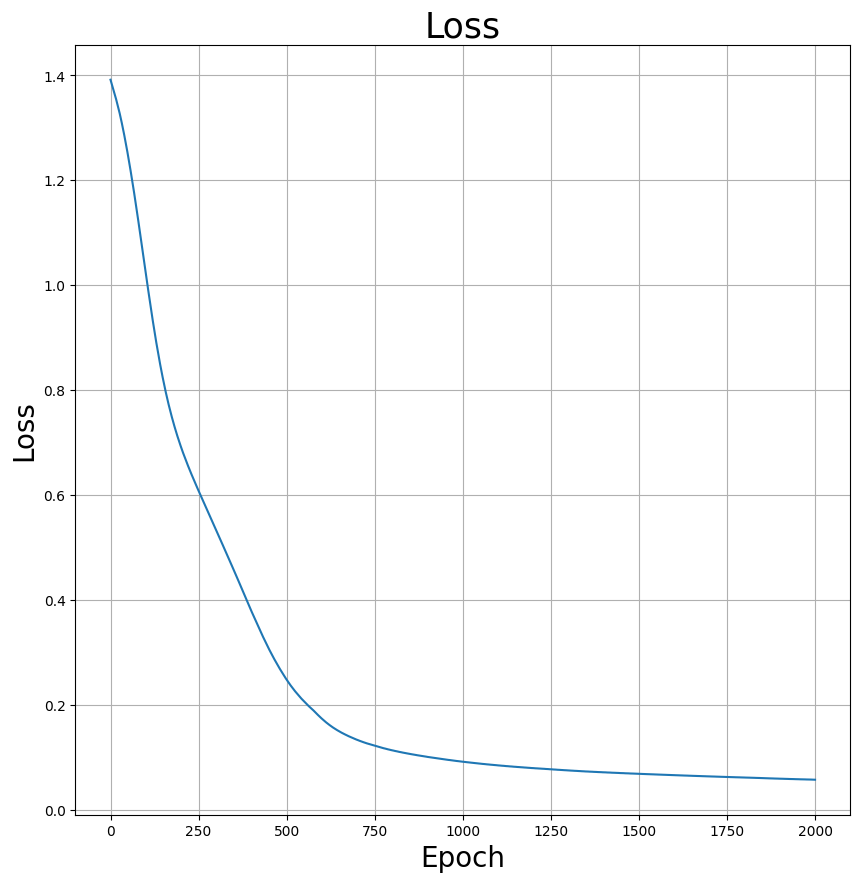

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
plt.plot(historico['Epoch'],historico['Loss'],label='Loss')
plt.title('Loss',fontsize = 25)
plt.xlabel('Epoch',fontsize = 20)
plt.ylabel('Loss',fontsize = 20)
plt.grid()
plt.show()

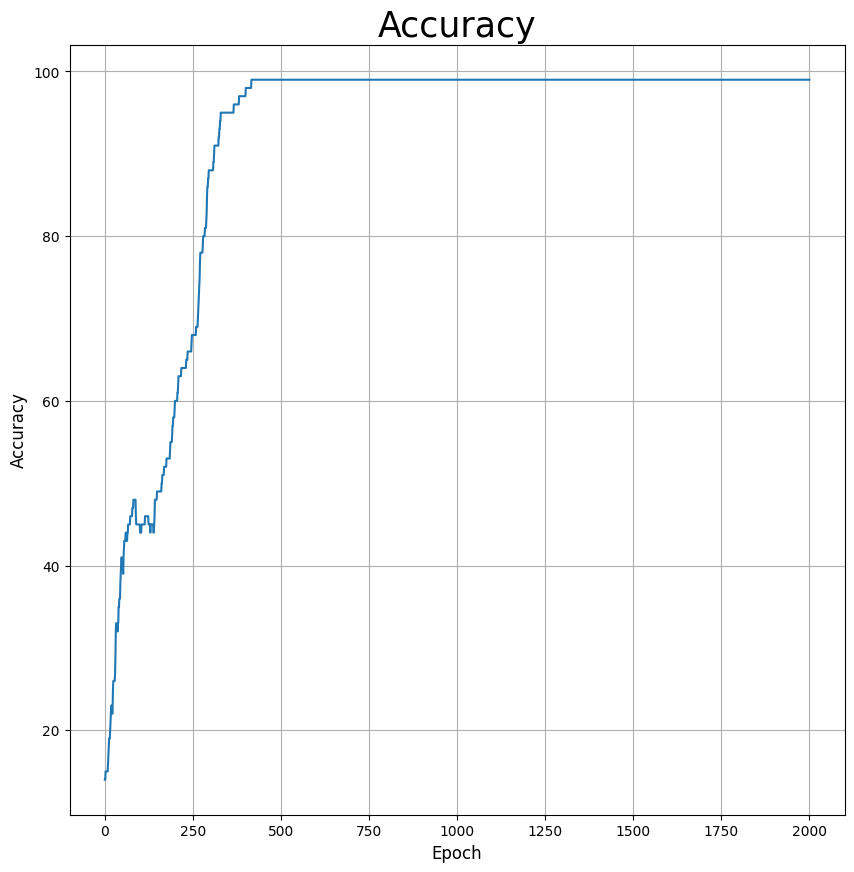

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historico['Epoch'],historico['Accuracy'], label='Accuracy')
plt.title('Accuracy',fontsize = 25)
plt.xlabel('Epoch',fontsize = 12)
plt.ylabel('Accuracy',fontsize = 12)
plt.grid()
plt.show()

In [ ]:
tensor_X_test[40]

tensor([-0.2249,  0.8079,  0.8063, -1.0096], device='cuda:0')

In [ ]:
X_norm_np = tensor_X_test[40].cpu().numpy().reshape(1,-1)
X_original_np = escalador.inverse_transform(X_norm_np)
print("valor normalizado",X_norm_np)
print("valor original desnormalizado",X_original_np)

valor normalizado [[-0.22485591  0.80787015  0.8062923  -1.0096158 ]]
valor original desnormalizado [[23.96  7.4   2.    0.87]]


In [ ]:
prediccion = model(tensor_X_test[40])
print(prediccion)

tensor([ 11.9891,  14.9289,   3.7963, -19.9270], device='cuda:0',
       grad_fn=<ViewBackward0>)


In [ ]:
import numpy as np

def predecir_tupla(model,escalador,tupla):
  model.eval()
  device =next(model.parameters()).device

  datos = np.array([tupla])

  datos_norm = escalador.transform(datos)

  tensor_input = torch.from_numpy(datos_norm).float().to(device)

  with torch.no_grad():
    prediccion = model(tensor_input)

  return prediccion

In [ ]:
IMC = 24
h_sueño = 3
act_fisica = 0
relacion_c = 1

clase_predicha = predecir_tupla(model,escalador,[IMC,h_sueño,act_fisica,relacion_c])
print(clase_predicha)

tensor([[-16.1044, -12.5194,   5.6215,  24.1001]], device='cuda:0')


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
torch.save(model.state_dict(),'modelo_nutricionista.pth')

In [ ]:
import joblib

joblib.dump(escalador,'escalador.save')

['escalador.save']